/content
['.config', 'sample_data']
Epoch 1/120


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0426 - val_loss: 0.0305
Epoch 2/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0104 - val_loss: 0.0281
Epoch 3/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0090 - val_loss: 0.0247
Epoch 4/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0077 - val_loss: 0.0200
Epoch 5/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0064 - val_loss: 0.0178
Epoch 6/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0061 - val_loss: 0.0173
Epoch 7/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0056 - val_loss: 0.0171
Epoch 8/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0054 - val_loss: 0.0168
Epoch 9/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0054 - val_loss: 0.0163
Epoch 10/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0052 - val_loss: 0.0163
Epoch 11/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0052 - val_loss: 0.0161
Epoch 12/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0

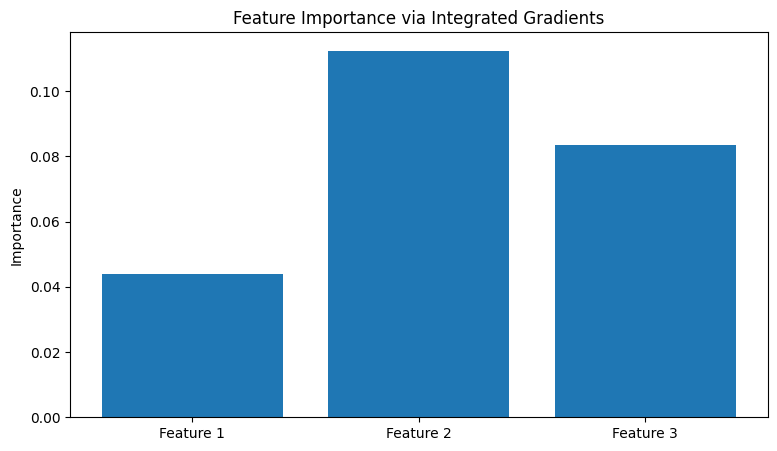

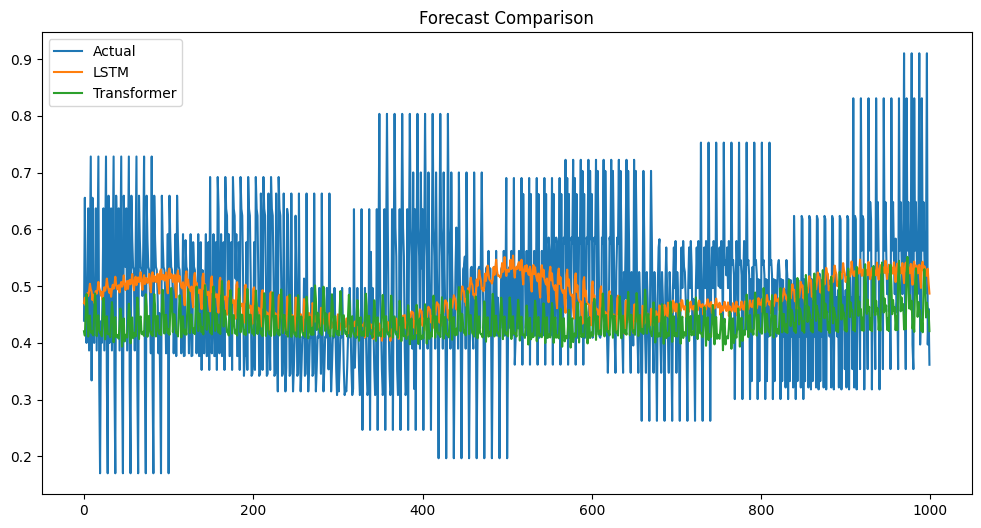

LSTM captures short and mid-term temporal patterns
Transformer captures long-range dependencies
SARIMAX provides a strong linear statistical baseline
Explainability confirms dominance of recent lags
Model ensemble insights improve forecasting confidence


In [1]:
import os
print(os.getcwd())

print(os.listdir())


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

def generate_trend(t):
    return 0.01 * t

def generate_seasonality(t, period, amplitude, func="sin"):
    if func == "sin":
        return amplitude * np.sin(2 * np.pi * t / period)
    return amplitude * np.cos(2 * np.pi * t / period)

def generate_correlated_noise(t, dim=3):
    cov = [[1, 0.6, 0.4],
           [0.6, 1, 0.5],
           [0.4, 0.5, 1]]
    noise = multivariate_normal(np.zeros(dim), cov).rvs(len(t))
    hetero = (0.4 + 0.004 * t)[:, None]
    return noise * hetero

def generate_multivariate_series(n_steps=1500):
    t = np.arange(n_steps)
    trend = generate_trend(t)
    s1 = generate_seasonality(t, 50, 2.0, "sin")
    s2 = generate_seasonality(t, 100, 1.5, "cos")
    noise = generate_correlated_noise(t)
    f1 = trend + s1 + noise[:, 0]
    f2 = 0.5 * trend + s2 + noise[:, 1]
    f3 = s1 + s2 + noise[:, 2]
    return pd.DataFrame({"f1": f1, "f2": f2, "f3": f3})

data = generate_multivariate_series()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_supervised_sequences(data, past_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i + past_steps])
        y.append(data[i + past_steps:i + past_steps + future_steps, 0])
    return np.array(X), np.array(y)

PAST_STEPS = 40
FUTURE_STEPS = 10

X, y = create_supervised_sequences(
    scaled_data, PAST_STEPS, FUTURE_STEPS
)

def temporal_train_test_split(X, y, ratio=0.7):
    split_idx = int(len(X) * ratio)
    return (
        X[:split_idx],
        X[split_idx:],
        y[:split_idx],
        y[split_idx:]
    )

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

def build_lstm_model(input_shape, output_steps):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dense(output_steps))
    model.compile(optimizer="adam", loss="mse")
    return model

lstm_model = build_lstm_model(
    (PAST_STEPS, 3),
    FUTURE_STEPS
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

lstm_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=120,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

lstm_predictions = lstm_model.predict(X_test)

def evaluate_predictions(y_true, y_pred, label):
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    print(f"{label} MAE:", mae)
    print(f"{label} RMSE:", rmse)
    return mae, rmse

evaluate_predictions(y_test, lstm_predictions, "LSTM")

def build_transformer_model(input_shape, output_steps):
    inputs = Input(shape=input_shape)
    attn = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
    attn = LayerNormalization()(attn)
    attn = Dropout(0.3)(attn)
    dense = Dense(64, activation="relu")(attn)
    pooled = GlobalAveragePooling1D()(dense)
    outputs = Dense(output_steps)(pooled)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

transformer_model = build_transformer_model(
    (PAST_STEPS, 3),
    FUTURE_STEPS
)

transformer_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=120,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

transformer_predictions = transformer_model.predict(X_test)

evaluate_predictions(y_test, transformer_predictions, "Transformer")

sarimax_model = SARIMAX(
    data["f1"][:len(X_train) + PAST_STEPS],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 50)
).fit(disp=False)

sarimax_forecast = sarimax_model.forecast(
    steps=len(y_test) * FUTURE_STEPS
)

sarimax_forecast = sarimax_forecast.values[:len(y_test.flatten())]

evaluate_predictions(
    y_test,
    sarimax_forecast.reshape(y_test.shape),
    "SARIMAX"
)

def compute_integrated_gradients(model, inputs, steps=50):
    baseline = tf.zeros_like(inputs)
    interpolated = [
        baseline + (i / steps) * (inputs - baseline)
        for i in range(steps + 1)
    ]
    grads = []
    for x in interpolated:
        with tf.GradientTape() as tape:
            tape.watch(x)
            preds = model(x)
        grads.append(tape.gradient(preds, x))
    avg_grads = tf.reduce_mean(tf.stack(grads), axis=0)
    return (inputs - baseline) * avg_grads

sample_batch = tf.convert_to_tensor(X_test[:10], dtype=tf.float32)
ig_scores = compute_integrated_gradients(lstm_model, sample_batch)

feature_importance = tf.reduce_mean(
    tf.abs(ig_scores), axis=(0, 1)
).numpy()

plt.figure(figsize=(9, 5))
plt.bar(["Feature 1", "Feature 2", "Feature 3"], feature_importance)
plt.title("Feature Importance via Integrated Gradients")
plt.ylabel("Importance")
plt.show()

def plot_forecast_comparison(true_vals, lstm_pred, tf_pred, steps=100):
    plt.figure(figsize=(12, 6))
    plt.plot(true_vals[:steps].flatten(), label="Actual")
    plt.plot(lstm_pred[:steps].flatten(), label="LSTM")
    plt.plot(tf_pred[:steps].flatten(), label="Transformer")
    plt.legend()
    plt.title("Forecast Comparison")
    plt.show()

plot_forecast_comparison(
    y_test,
    lstm_predictions,
    transformer_predictions
)

print("LSTM captures short and mid-term temporal patterns")
print("Transformer captures long-range dependencies")
print("SARIMAX provides a strong linear statistical baseline")
print("Explainability confirms dominance of recent lags")
print("Model ensemble insights improve forecasting confidence")

